<div class="alert alert-block alert-warning">
Scenario analysis
</div>

In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.

    Slack is defined as:
        Slack_ac = (Total flight time of aircraft ac) / H
    where H is the total scenario horizon (difference in minutes between the earliest departure and the latest arrival).

    The scenario slack is the average slack across all aircraft.
    """
    flights = scenario_data.get('flights', {})
    aircraft_ids = scenario_data.get('aircraft_ids', [])

    if len(flights) == 0:
        # No flights: scenario slack = 0
        return 0.0

    # Identify the overall scenario horizon
    dep_times = [time_to_minutes(f_data['DepTime']) for f_data in flights.values()]
    arr_times = [time_to_minutes(f_data['ArrTime']) for f_data in flights.values()]
    earliest_dep = min(dep_times)
    latest_arr = max(arr_times)
    horizon = max(latest_arr - earliest_dep, 1)  # Ensure no division by zero

    # Organize flights by aircraft
    aircraft_flights = {ac: [] for ac in aircraft_ids}
    for f_data in flights.values():
        dep = time_to_minutes(f_data['DepTime'])
        arr = time_to_minutes(f_data['ArrTime'])
        ac = f_data['Aircraft']
        aircraft_flights[ac].append((dep, arr))

    # Calculate slack per aircraft
    aircraft_slacks = []
    for ac, f_list in aircraft_flights.items():
        if len(f_list) == 0:
            # No flights for this aircraft: slack = 0
            ac_slack = 0.0
        else:
            total_flight_time = sum(arr - dep for dep, arr in f_list)
            ac_slack = total_flight_time / horizon
        aircraft_slacks.append(ac_slack)

    # Scenario slack is the average slack of all aircraft
    scenario_slack = sum(aircraft_slacks) / len(aircraft_slacks) if aircraft_slacks else 0.0
    return scenario_slack

def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    # Calculate average probability of all aircraft:
    # For each aircraft, find the max probability of any disruption it faces.
    # If no disruption, probability = 0.0
    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  # default 0.0 if no disruptions

    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob

# Path to the scenarios folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max(
    [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
    key=lambda x: int(x.split('_')[-1].replace('.json', ''))
)

latest_folder = "scenario_folder_scenario_2.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']

# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)

# Save the slack results to CSV
output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
scenarios_df.to_csv(output_file, index=False)
print(f"Slack metrics saved to {output_file}")


Scenario ID: 2
Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario  ScenarioSlack  FullyDisruptedCount  \
0    deterministic_na_Scenario_001       0.668537                    2   
1    deterministic_na_Scenario_002       0.663849                    2   
2    deterministic_na_Scenario_003       0.709877                    2   
3    deterministic_na_Scenario_004       0.593474                    2   
4    deterministic_na_Scenario_005       0.702314                    2   
..                             ...            ...                  ...   
695        mixed_high_Scenario_096       0.684293                    1   
696        mixed_high_Scenario_097       0.680254                    1   
697        mixed_high_Scenario_098       0.664708                    1   
698        mixed_high_Scenario_099       0.658414                    1   
699        mixed_high_Scenario_100       0.657952                    1   

     UncertainCount  AvgAircraftProbability  AvgUn

<div class="alert alert-block alert-warning">
Inferencing
</div>

In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import time

from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.utils import load_scenario_data, NumpyEncoder, get_training_metadata
from scripts.logger import create_new_id, log_inference_metadata, find_corresponding_training_id, convert_to_serializable

def run_inference_dqn_single(model_path, scenario_folder, env_type, seed):
    """
    Runs inference on a single scenario and returns the total reward.
    """
    start_time = time.time()
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )

    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    while not done_flag and step_num < max_steps:
        action_mask = obs['action_mask']
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        # If no valid actions remain, break out
        if np.all(np.isinf(masked_q_values)):
            break

        action = np.argmax(masked_q_values)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        step_num += 1

    total_delays = env.scenario_wide_delay_minutes
    total_cancelled_flights = env.scenario_wide_cancelled_flights
    end_time = time.time()
    scenario_time = end_time - start_time
    scenario_steps = env.scenario_wide_steps
    scenario_resolved_conflicts = env.scenario_wide_resolved_conflicts
    solution_slack = env.scenario_wide_solution_slack

    return total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack

def run_inference_on_data_folder(model_paths, data_folder, seeds):
    """
    Runs inference on all scenarios found in 'data_folder', for each model in 'model_paths' and each seed in 'seeds'.

    Args:
        model_paths (list): List of model paths to run inference with.
        data_folder (str): Path to the folder containing scenario subfolders.
        env_type (str): Type of environment ("myopic", "proactive", "reactive").
        seeds (list): List of seeds for reproducibility.

    Returns:
        pd.DataFrame: A DataFrame containing scenario, model, seed, and total reward.
    """

    # Identify all scenario folders within data_folder
    scenario_folders = [
        os.path.join(data_folder, folder)
        for folder in os.listdir(data_folder)
        if os.path.isdir(os.path.join(data_folder, folder))
    ]

    results = []
    for scenario_folder in scenario_folders:
        scenario_name = os.path.basename(scenario_folder)
        for model_path in model_paths:
            for seed in seeds:
                # extract env_type from model_path
                env_type = model_path.split("/")[-2]
                total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack = run_inference_dqn_single(model_path, scenario_folder, env_type, seed)
                results.append({
                    "Scenario": scenario_name,
                    "Model": os.path.basename(model_path),
                    "Seed": seed,
                    "TotalReward": total_reward,
                    "TotalDelays": total_delays,
                    "TotalCancelledFlights": total_cancelled_flights,
                    "ScenarioTime": scenario_time,
                    "ScenarioSteps": scenario_steps,
                    "ScenarioResolvedConflicts": scenario_resolved_conflicts,
                    "SolutionSlack": solution_slack
                })

    results_df = pd.DataFrame(results)
    return results_df


# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

data_folder = data['data_folder']
print(f"inferencing on data folder: {data_folder}")

# Define models and seeds
model_paths = [
    # "../trained_models/dqn/6ac-700-diverse/23/myopic-training_8.zip",
    # "../trained_models/dqn/6ac-700-diverse/23/proactive-training_9.zip",
    # "../trained_models/dqn/6ac-700-diverse/23/reactive-training_10.zip"
    "../trained_models/dqn/6ac-700-diverse/23/myopic-training_13.zip"
]
seeds = [25, 26]

results_df = run_inference_on_data_folder(model_paths, data_folder, seeds)



inferencing on data folder: ../data/Testing/6ac-700-diverse/


<div class="alert alert-block alert-success">
Merging scenario data and inference data
</div>

In [3]:
# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

print("Inference Results (After Merging):")
print(merged_df.head(20))

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")

# print all column names
# print(results_df.columns)



Inference Results (After Merging):
                        Scenario                   Model  Seed  TotalReward  \
0      mixed_medium_Scenario_015  myopic-training_13.zip    25      -9567.7   
1      mixed_medium_Scenario_015  myopic-training_13.zip    26      -9567.7   
2         mixed_low_Scenario_077  myopic-training_13.zip    25     -11220.4   
3         mixed_low_Scenario_077  myopic-training_13.zip    26     -11220.4   
4   stochastic_high_Scenario_073  myopic-training_13.zip    25     -12970.4   
5   stochastic_high_Scenario_073  myopic-training_13.zip    26     -12970.4   
6         mixed_low_Scenario_083  myopic-training_13.zip    25      -4184.7   
7         mixed_low_Scenario_083  myopic-training_13.zip    26      -4184.7   
8   stochastic_high_Scenario_087  myopic-training_13.zip    25      -6872.2   
9   stochastic_high_Scenario_087  myopic-training_13.zip    26      -6872.2   
10        mixed_low_Scenario_048  myopic-training_13.zip    25     -11136.8   
11        mixed_l

<div class="alert alert-block alert-warning">
Comparison of Models Across All Scenarios
</div>

In [4]:
import pandas as pd

comparison_table = (
    merged_df
    .groupby('Model')
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Mean_Delays=('TotalDelays', 'mean'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
        Mean_ResolvedConflicts=('ScenarioResolvedConflicts', 'mean'),
    )
    .round(2)
)

print("Comparison of Models Across All Scenarios:")
print(comparison_table)


Comparison of Models Across All Scenarios:
                        Mean_Reward  Mean_Runtime  Mean_Steps  Mean_Delays  \
Model                                                                        
myopic-training_13.zip     -9907.88          0.03        7.22      1027.79   

                        Mean_CancelledFlights  Mean_ResolvedConflicts  
Model                                                                  
myopic-training_13.zip                   1.35                    0.87  


<div class="alert alert-block alert-warning">
Comparison of Models Across stochastic_low and stochastic_high Scenarios
</div>

In [5]:
import pandas as pd
import numpy as np

# Filter scenarios that start with 'stochastic_low' or 'stochastic_high'
filtered_df = merged_df[
    merged_df['Scenario'].str.startswith('stochastic_low') | 
    merged_df['Scenario'].str.startswith('stochastic_high')
]

# Create a scenario type column for easier grouping
filtered_df['ScenarioType'] = np.where(
    filtered_df['Scenario'].str.startswith('stochastic_low'), 
    'stochastic_low', 
    'stochastic_high'
)

# Group by Model and ScenarioType and compute the desired metrics
inference_table = (
    filtered_df
    .groupby(['Model', 'ScenarioType'])
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Mean_Delays=('TotalDelays', 'mean'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
        Mean_ResolvedConflicts=('ScenarioResolvedConflicts', 'mean')
    )
    .round(2)
    .reset_index()
)

# Pivot the table to compare models across scenario types in columns
inference_table_pivot = inference_table.pivot(index='Model', columns='ScenarioType')
# Flatten column names
inference_table_pivot.columns = ['_'.join(col).strip() for col in inference_table_pivot.columns.values]

print("Comparison of Models Across stochastic_low and stochastic_high Scenarios:")
print(inference_table_pivot)


Comparison of Models Across stochastic_low and stochastic_high Scenarios:
                        Mean_Reward_stochastic_high  \
Model                                                 
myopic-training_13.zip                    -11025.16   

                        Mean_Reward_stochastic_low  \
Model                                                
myopic-training_13.zip                     -9777.3   

                        Mean_Runtime_stochastic_high  \
Model                                                  
myopic-training_13.zip                          0.03   

                        Mean_Runtime_stochastic_low  \
Model                                                 
myopic-training_13.zip                         0.03   

                        Mean_Steps_stochastic_high  Mean_Steps_stochastic_low  \
Model                                                                           
myopic-training_13.zip                        7.24                       7.16   

                  

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_73284/1350057505.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ScenarioType'] = np.where(


<div class="alert alert-block alert-warning">
Reward vs. AvgUncertaintyProbability (stochastic scenarios)
</div>

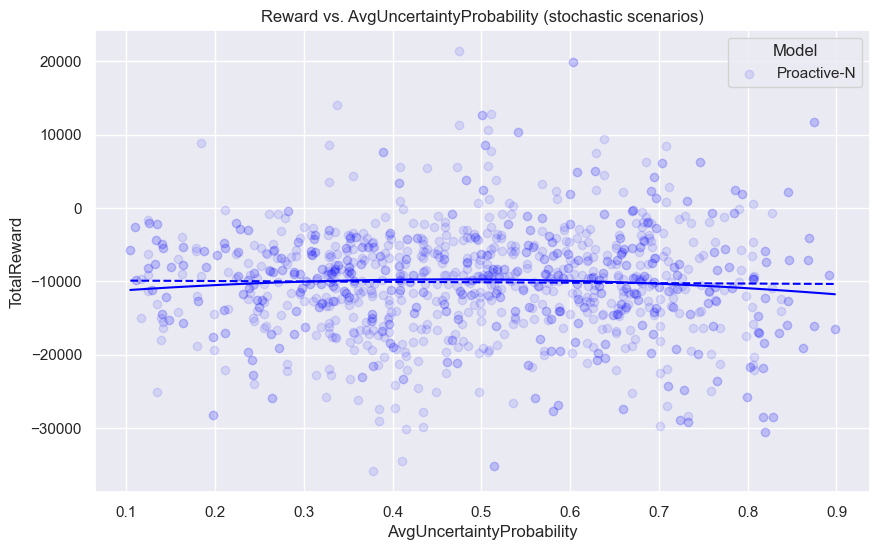

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Filter the DataFrame for stochastic_low, stochastic_medium, and stochastic_high scenarios
filtered_stochastic_df = merged_df[
    merged_df['Scenario'].str.startswith('stochastic_low') |
    merged_df['Scenario'].str.startswith('stochastic_medium') |
    merged_df['Scenario'].str.startswith('stochastic_high') |
    merged_df['Scenario'].str.startswith('mixed_low') |
    merged_df['Scenario'].str.startswith('mixed_medium') |
    merged_df['Scenario'].str.startswith('mixed_high')
]

# Define a color map for the models
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in filtered_stochastic_df['Model'].unique()
}

plt.figure(figsize=(10, 6))

# Plot each model separately with regression lines
for model_name, (color, label) in model_colors.items():
    model_data = filtered_stochastic_df[filtered_stochastic_df['Model'] == model_name]
    x = model_data['AvgUncertaintyProbability'].values.reshape(-1, 1)
    y = model_data['TotalReward'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Reward vs. AvgUncertaintyProbability (stochastic scenarios)")
plt.xlabel("AvgUncertaintyProbability")
plt.ylabel("TotalReward")
plt.legend(title="Model")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-warning">
Reward vs. AvgAircraftProbability (all scenarios)
</div>

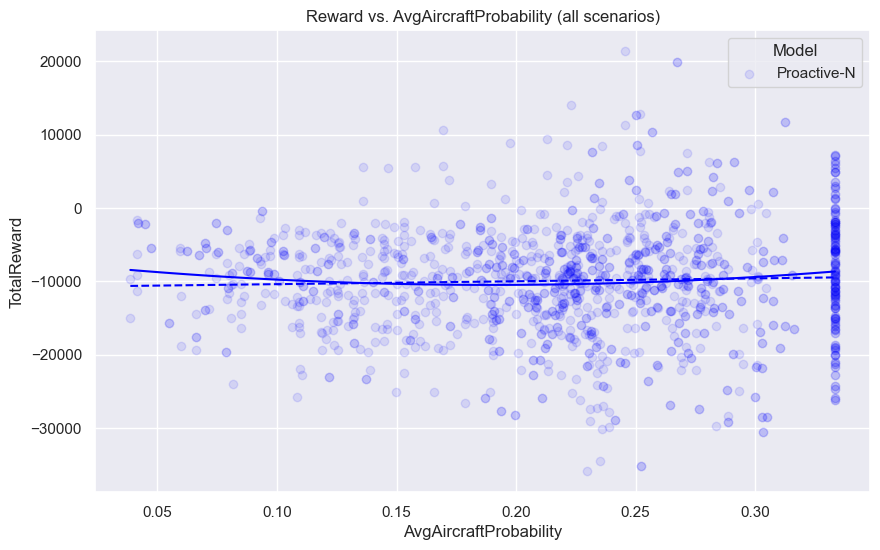

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define a color map for the models with custom labels
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green',
        'Proactive-U' if 'proactive' in model_name.lower() else
        'Proactive-N' if 'myopic' in model_name.lower() else
        'Reactive'
    )
    for model_name in filtered_stochastic_df['Model'].unique()
}

plt.figure(figsize=(10, 6))

# Plot each model separately with regression lines
for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    x = model_data['AvgAircraftProbability'].values.reshape(-1, 1)
    y = model_data['TotalReward'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Reward vs. AvgAircraftProbability (all scenarios)")
plt.xlabel("AvgAircraftProbability")
plt.ylabel("TotalReward")
plt.legend(title="Model")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-warning">
Reward vs. ScenarioSlack (all scenarios)
</div>

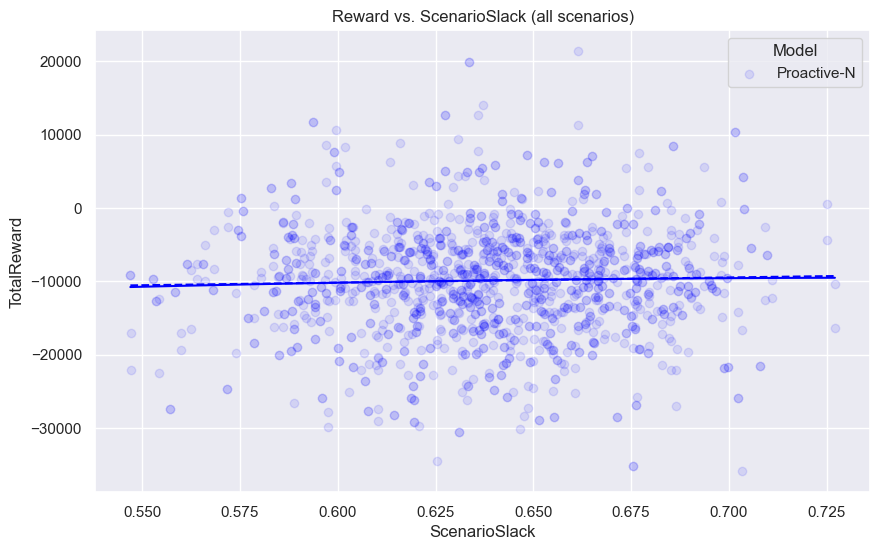

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


plt.figure(figsize=(10, 6))

for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    x = model_data['ScenarioSlack'].values.reshape(-1, 1)
    y = model_data['TotalReward'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2) for a smoothed curve
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Reward vs. ScenarioSlack (all scenarios)")
plt.xlabel("ScenarioSlack")
plt.ylabel("TotalReward")
plt.legend(title="Model")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-warning">
TotalDelay vs. AvgAircraftProbability (all scenarios)
</div>

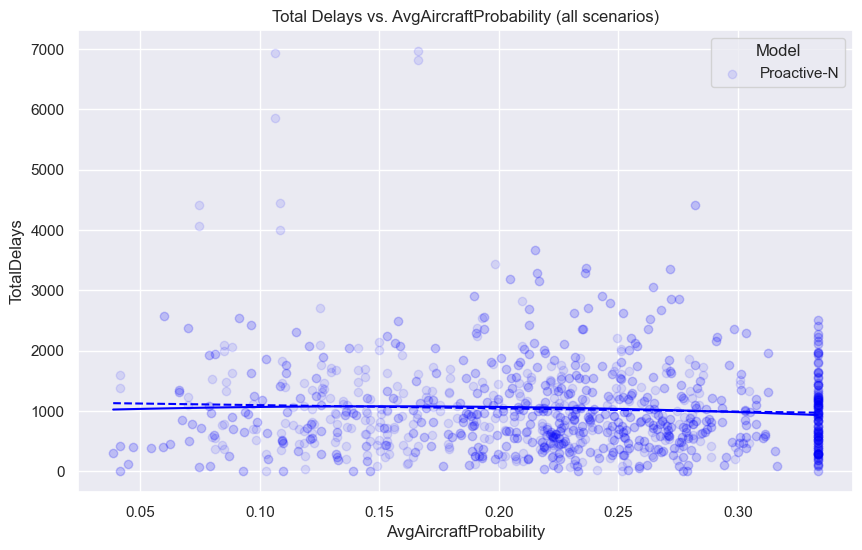

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


plt.figure(figsize=(10, 6))

for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    x = model_data['AvgAircraftProbability'].values.reshape(-1, 1)
    y = model_data['TotalDelays'].values
    
    # Plot scatter points
    plt.scatter(
        x, y,
        c=color,
        label=label,
        alpha=0.1
    )
    
    # Linear regression (degree 1)
    lr = LinearRegression()
    lr.fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = lr.predict(x_pred)
    plt.plot(x_pred, y_pred, '--', color=color, alpha=1)
    
    # Polynomial regression (degree 2) for a smoothed curve
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    lr2 = LinearRegression()
    lr2.fit(x_poly, y)
    x_pred_poly = poly.transform(x_pred)
    y_pred_poly = lr2.predict(x_pred_poly)
    plt.plot(x_pred, y_pred_poly, '-', color=color, alpha=1)

plt.title("Total Delays vs. AvgAircraftProbability (all scenarios)")
plt.xlabel("AvgAircraftProbability")
plt.ylabel("TotalDelays")
plt.legend(title="Model")
plt.grid(True)
plt.show()


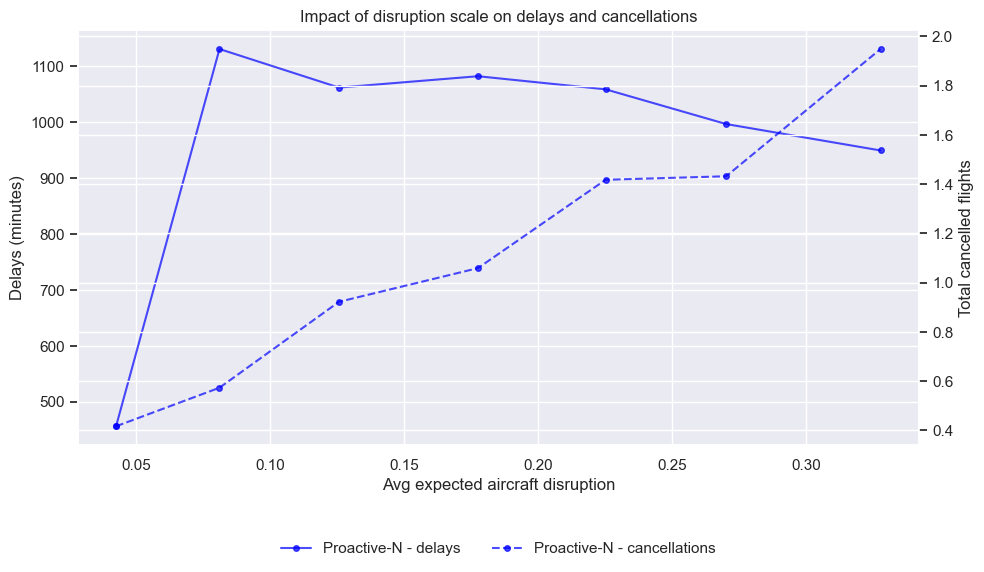

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")



fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Define bucket boundaries
buckets = np.arange(0, 1.05, 0.05)  # Creates buckets 0-0.05, 0.05-0.1, etc.

# Add grid with low zorder so it's behind the data
ax1.grid(True, zorder=1)

for model_name, (color, label) in model_colors.items():
    model_data = merged_df[merged_df['Model'] == model_name]
    
    # Initialize lists to store bucket averages
    x_means = []
    y_means = []
    y2_means = []
    
    # Calculate averages for each bucket
    for i in range(len(buckets)-1):
        bucket_data = model_data[
            (model_data['AvgAircraftProbability'] >= buckets[i]) & 
            (model_data['AvgAircraftProbability'] < buckets[i+1])
        ]
        
        if not bucket_data.empty:
            x_means.append(bucket_data['AvgAircraftProbability'].mean())
            y_means.append(bucket_data['TotalDelays'].mean())
            y2_means.append(bucket_data['TotalCancelledFlights'].mean())
    
    # Plot the bucket averages for TotalDelays on first y-axis with higher zorder
    ax1.plot(x_means, y_means,
             color=color,
             label=f"{label} - delays",
             marker='o',
             markersize=4,
             alpha=0.7,
             zorder=5)
             
    # Plot the bucket averages for TotalCancelledFlights on second y-axis with higher zorder
    ax2.plot(x_means, y2_means,
             color=color,
             label=f"{label} - cancellations",
             linestyle='--',
             marker='o',
             markersize=4,
             alpha=0.7,
             zorder=5)

ax1.set_xlabel("Avg expected aircraft disruption")
ax1.set_ylabel("Delays (minutes)")
ax2.set_ylabel("Total cancelled flights")

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0.5, -0.25), loc='center', ncol=3, frameon=False)

plt.title("Impact of disruption scale on delays and cancellations")
plt.tight_layout()
plt.show()
